In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [2]:
data = pd.read_csv('data/cleaned_counties.csv').fillna(0)
print(data.shape)
data.head()

(2457, 19)


,FIPS,State,County,Population,Hispanic,White,Black,Native,Asian,Pacific,Income,Poverty,Unemployment,Civilian Labor Force,Grocery Stores,Supercenters,Convenience Stores,Specialty Stores,Total Stores
0,1001,Alabama,Autauga,55035,2.6,75.8,18.5,0.4,1.0,0.0,51281.0,12.9,7.6,25602,4,1,30,2,37
1,1003,Alabama,Baldwin,203690,4.5,83.1,9.5,0.6,0.7,0.0,50254.0,13.4,7.5,87705,29,6,118,26,179
2,1005,Alabama,Barbour,26270,4.6,46.2,46.7,0.2,0.4,0.0,32964.0,26.7,17.6,8609,5,1,19,2,27
3,1007,Alabama,Bibb,22561,2.2,74.5,21.4,0.4,0.1,0.0,38678.0,16.8,8.3,8572,5,1,15,1,22
4,1009,Alabama,Blount,57676,8.6,87.9,1.5,0.3,0.1,0.0,45813.0,16.7,7.7,24473,6,1,27,0,34


In [3]:
data = data.fillna(0)

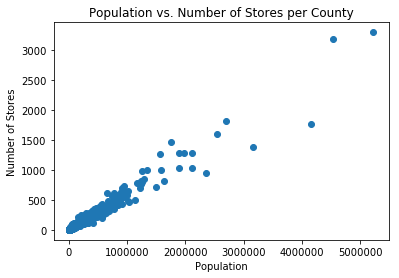

In [4]:
plt.scatter(data["Population"], data["Total Stores"])
plt.title("Population vs. Number of Stores per County")
plt.xlabel("Population")
plt.ylabel("Number of Stores")
plt.show()

As population increases, so do the total number of stores.

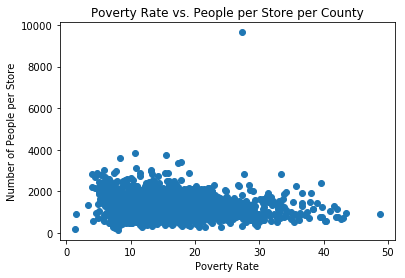

In [5]:
plt.scatter(data["Poverty"], data['Population']/data["Total Stores"])
plt.title("Poverty Rate vs. People per Store per County")
plt.xlabel("Poverty Rate")
plt.ylabel("Number of People per Store")
plt.show()

There does not seem to be any connection between the poverty rate and the number of people per store. There is one outlier which might be interesting to investigate.

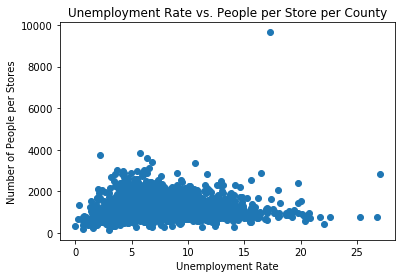

In [6]:
plt.scatter(data["Unemployment"], data['Population']/data["Total Stores"])
plt.title("Unemployment Rate vs. People per Store per County")
plt.xlabel("Unemployment Rate")
plt.ylabel("Number of People per Stores") 
plt.show()

There does not seem to be any connection between the unemployment rate and the number of people per store. There is one outlier which might be interesting to investigate.

In [7]:
# dataframe of the features
X = data.loc[:, ["Hispanic", "White", "Black", "Native", "Asian", "Pacific", "Income", "Poverty", "Unemployment"]]
X["Civilian Labor Force %"] = data['Civilian Labor Force'] / data["Population"] * 100
X.head()

,Hispanic,White,Black,Native,Asian,Pacific,Income,Poverty,Unemployment,Civilian Labor Force %
0,2.6,75.8,18.5,0.4,1.0,0.0,51281.0,12.9,7.6,46.519488
1,4.5,83.1,9.5,0.6,0.7,0.0,50254.0,13.4,7.5,43.058078
2,4.6,46.2,46.7,0.2,0.4,0.0,32964.0,26.7,17.6,32.771222
3,2.2,74.5,21.4,0.4,0.1,0.0,38678.0,16.8,8.3,37.994770
4,8.6,87.9,1.5,0.3,0.1,0.0,45813.0,16.7,7.7,42.431861


In [8]:
# list of the target, people per store
y = data['Population'] / data['Total Stores']
y = y.replace(float('inf'), value = 0)
y.head()

0    1487.432432
1    1137.932961
2     972.962963
3    1025.500000
4    1696.352941
dtype: float64

In [21]:
# compute covariance between each feature and people per store
all_ = X.copy(deep=True)
all_['People per Store'] = y
all_.cov().loc[:, ['People per Store']]

,People per Store
Hispanic,6.390389e+02
White,-4.104964e+02
Black,-5.703030e+02
Native,-5.006583e+01
Asian,2.882093e+02
Pacific,8.830140e+00
Income,2.081861e+06
Poverty,-5.272893e+02
Unemployment,3.680510e+01
Civilian Labor Force %,-2.627420e+01


In [9]:
# divide up data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1965, 10) (492, 10) (1965,) (492,)


In [29]:
# create multiple regression model
clf = ensemble.GradientBoostingRegressor(learning_rate=.05)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [30]:
clf.score(X_test, y_test)

0.25012487958092811

In [31]:
# cross validation score
scores = cross_val_score(clf, X, y, cv=10)
print('Average Score:', np.mean(scores))
print('SD of Score:', np.std(scores))

Average Score: 0.258174073616
SD of Score: 0.0991935256278


In [13]:
predictions = clf.predict(X_test)

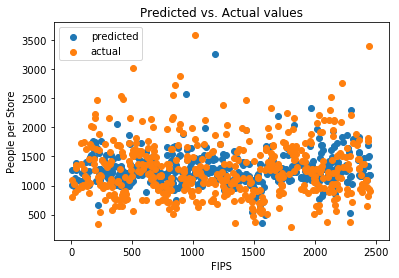

In [14]:
plt.scatter(X_test.index, predictions, label='predicted')
plt.scatter(X_test.index, y_test, label='actual')
plt.title("Predicted vs. Actual values")
plt.xlabel("FIPS")
plt.ylabel("People per Store")
plt.legend()
plt.show()

In [15]:
results = data.loc[:, ['FIPS', 'State', 'County']]
results['predicted'] = clf.predict(X)
results['actual'] = y
results.head()

,FIPS,State,County,predicted,actual
0,1001,Alabama,Autauga,1386.503187,1487.432432
1,1003,Alabama,Baldwin,1349.771589,1137.932961
2,1005,Alabama,Barbour,1330.107459,972.962963
3,1007,Alabama,Bibb,1090.658491,1025.500000
4,1009,Alabama,Blount,1287.529473,1696.352941


# Conclusion

The model has an $r^2$ (coefficient of determination) value of about 0.25. This means that about 25% of the variance of the y variable (people per store) can be accounted for by the set of features. Because using data about the demographics of the county, like race and poverty rate, explained so little of the variance of the y variable, it leads me to believe that there is not a strong correlation between the demographics of a county and the occurance of stores. The unaccounted for variance could be caused by the geographic size of the county or the type of county it is. I used population size to adjust the number of stores for each county. However, a better metric to use for adjustment could be the geographic size of the county. In addition, if the county is a rural, farming county, there are more likely to be fewer stores because more people would buy their groceries from farmers markets and local stores. Further analysis is needed to determine if these factors could better explain the variance in number of people per store.